In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torchvision.datasets.utils import download_url
import zipfile

cudnn.benchmark = True
plt.ion() 

In [2]:
from torchvision.datasets.utils import download_url
import zipfile
import os

# URL for the dataset
dataset_url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
output_zip = "hymenoptera_data.zip"
data_dir = "data/hymenoptera_data"  # Target directory

# Step 1: Download the dataset
print("Downloading dataset...")
download_url(dataset_url, root=".", filename=output_zip, md5=None)
print(f"Dataset downloaded as {output_zip}")

# Step 2: Extract the dataset
print("Extracting dataset...")
os.makedirs(data_dir, exist_ok=True)  # Ensure the directory exists
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall("data")  # Extract to the "data" directory
print(f"Dataset extracted to {data_dir}")

# Step 3: Clean up the ZIP file (optional)
os.remove(output_zip)
print(f"Removed ZIP file: {output_zip}")

# Ensure the required directory exists
train_dir = os.path.join(data_dir, "train")
if os.path.exists(train_dir):
    print(f"Train directory available: {train_dir}")
else:
    print(f"Error: Train directory not found!")


0.5%

100.0%


Dataset downloaded as hymenoptera_data.zip
Extracting dataset...
Dataset extracted to data/hymenoptera_data
Removed ZIP file: hymenoptera_data.zip
Train directory available: data/hymenoptera_data/train


In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

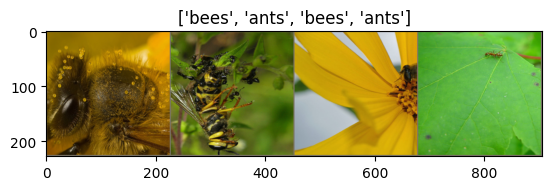

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6758 Acc: 0.6967
val Loss: 0.3418 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.4998 Acc: 0.7746
val Loss: 0.2930 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.6514 Acc: 0.7705
val Loss: 0.7195 Acc: 0.7974

Epoch 3/24
----------
train Loss: 0.8915 Acc: 0.7295
val Loss: 0.3356 Acc: 0.8627

Epoch 4/24
----------
train Loss: 0.7403 Acc: 0.7295
val Loss: 0.2787 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.5706 Acc: 0.8115
val Loss: 0.3593 Acc: 0.8562

Epoch 6/24
----------
train Loss: 0.5806 Acc: 0.7828
val Loss: 1.3616 Acc: 0.6405

Epoch 7/24
----------
train Loss: 0.6436 Acc: 0.8033
val Loss: 0.1872 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.4116 Acc: 0.8197
val Loss: 0.2176 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3617 Acc: 0.8443
val Loss: 0.1658 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.2448 Acc: 0.9016
val Loss: 0.1888 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.3661 Acc: 0.8402
val Loss: 0.1696 Acc: 0.9150

Ep

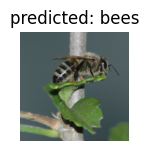

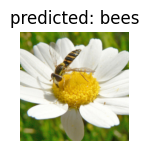

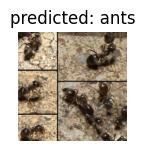

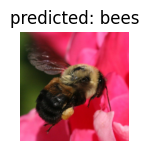

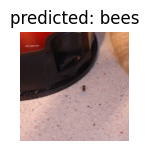

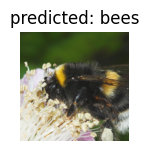

In [12]:
visualize_model(model_ft)


In [9]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [10]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5896 Acc: 0.6762
val Loss: 0.6208 Acc: 0.7059

Epoch 1/24
----------
train Loss: 0.4361 Acc: 0.7910
val Loss: 0.2033 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.3912 Acc: 0.8279
val Loss: 0.1857 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.4698 Acc: 0.7828
val Loss: 0.1878 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.3982 Acc: 0.8074
val Loss: 0.2026 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4835 Acc: 0.7828
val Loss: 0.2799 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.6130 Acc: 0.7787
val Loss: 0.2782 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.4157 Acc: 0.8197
val Loss: 0.1859 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3982 Acc: 0.8156
val Loss: 0.1906 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3704 Acc: 0.8607
val Loss: 0.2043 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3046 Acc: 0.8566
val Loss: 0.1882 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3754 Acc: 0.8238
val Loss: 0.2066 Acc: 0.9477

Ep

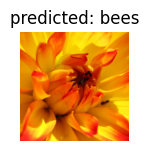

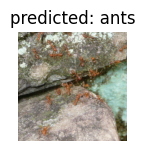

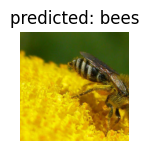

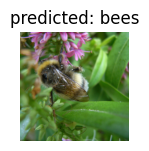

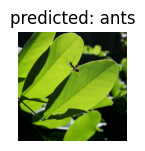

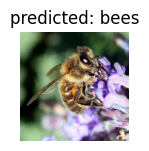

In [11]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [14]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

In [18]:
visualize_model_predictions(
    model_conv,
    img_path='data/hymenoptera_data/val/bees/72100438_73de9f17ag.jpg'
)

plt.ioff()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/avagrey/data/hymenoptera_data/val/bees/72100438_73de9f17ag.jpg'